In [1]:
import sys
sys.path.append('../../')

In [2]:
from functools import partial
from tqdm import trange
from typing import Dict

import numpy as np
import jax

import matplotlib.pyplot as plt
import jax.numpy as jnp

In [3]:
import flax
import flax.linen as nn
from flax.training.train_state import TrainState
import optax
import e3nn_jax as e3nn

from models.gnn import GNN
from models.segnn import SEGNN
from models.utils.graph_utils import build_graph

In [ ]:

from dataset_large import get_halo_dataset

2024-05-23 07:09:42.574583: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:

replicate = flax.jax_utils.replicate
unreplicate = flax.jax_utils.unreplicate    

In [ ]:
from models.utils.graph_utils import get_apply_pbc
from models.gnn import GNN
from models.segnn import SEGNN


from models.utils.graph_utils import build_graph
from models.utils.equivariant_graph_utils import get_equivariant_graph


In [ ]:
import scienceplots
plt.style.use('science')

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [ ]:

training_set_size = 15_000  

In [ ]:
features = ['x', 'y', 'z', 'vx', 'vy', 'vz']  # ['x', 'y', 'z', 'Jx', 'Jy', 'Jz', 'vx', 'vy', 'vz', 'M200c']
batch_size = 64

tfrecords_path = '/pscratch/sd/c/cuesta/equivariance/bsq'

dataset, num_total, mean, std, mean_params, std_params = get_halo_dataset(
    tfrecords_path=tfrecords_path,
    batch_size=batch_size,  
    num_samples=training_set_size,  
    split='train',  
    return_mean_std=True,  
    features=features,
)
std = np.array(std)
train_iterator = iter(dataset)
x_train, _ = next(train_iterator)


# predict some velocities
val_dataset, _ = get_halo_dataset(
    batch_size=batch_size,
    tfrecords_path=tfrecords_path,
    num_samples=250, 
    split='val',
    features=features,  
    )
val_iterator = iter(val_dataset)

2024-05-23 07:10:46.495515: W external/local_xla/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:510] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  ./cuda_sdk_lib
  /usr/local/cuda-12.3
  /usr/local/cuda
  /global/homes/c/cuesta/.conda/envs/jax_env/lib/python3.9/site-packages/tensorflow/python/platform/../../../nvidia/cuda_nvcc
  /global/homes/c/cuesta/.conda/envs/jax_env/lib/python3.9/site-packages/tensorflow/python/platform/../../../../nvidia/cuda_nvcc
  .
You can choose the search directory by setting xla_gpu_cuda_data_dir in HloModule's DebugOptions.  For most apps, setting the environment variable XLA_FLAGS=--xla_gpu_cuda_data_dir=/path/to/cuda will work.


In [ ]:
x_val, _ = next(val_iterator)
print(x_val.shape)

(64, 5000, 6)


In [ ]:
boxsize = 1000.
use_pbcs = True
apply_pbc = get_apply_pbc(std=std / boxsize,) if use_pbcs else None
k = 10
n_radial = 0 
position_features = True
use_3d_distances = False 
r_max = 0.6
l_max = 1
infill_value = -2.

In [ ]:
d_hidden = 128
n_layers = 3
message_passing_steps = 3
message_passing_agg = 'sum'
activation = 'gelu'
readout_agg = 'mean'
mlp_readout_widths = (4, 2, 2)
residual = True
GNN_PARAMS = {
    "d_hidden": d_hidden,
    "n_layers": n_layers,
    "message_passing_steps": message_passing_steps,
    "message_passing_agg": message_passing_agg,
    "activation": activation,
    "norm": "none",
    "task": "node",
    "n_outputs": 3,
    "readout_agg": "mean",
    "mlp_readout_widths": mlp_readout_widths,
    "position_features": True,
    "residual": residual,
}
SEGNN_PARAMS = {
    "d_hidden": d_hidden,
    "n_layers": n_layers,
    "message_passing_steps": message_passing_steps,
    "message_passing_agg": message_passing_agg,
    "scalar_activation": activation,
    "gate_activation": "sigmoid",
    "task": "node",
    "output_irreps": e3nn.Irreps("1x1o"),
    "readout_agg": "mean",
    "mlp_readout_widths": mlp_readout_widths,
    "l_max_hidden": 1,
    "hidden_irreps": None,
    "residual": residual,
}
    
class GraphWrapperGNN(nn.Module):
    param_dict: Dict
    @nn.compact
    def __call__(self, x):
        return jax.vmap(GNN(**self.param_dict))(x)
    

gnn = GraphWrapperGNN(GNN_PARAMS, )

In [ ]:

class GraphWrapper(nn.Module):
    param_dict: Dict

    @nn.compact
    def __call__(self, x):

        positions = e3nn.IrrepsArray("1o", x.nodes[..., :3])
        
        if x.nodes.shape[-1] == 3:
            nodes = e3nn.IrrepsArray("1o", x.nodes[..., :])
        else:
            nodes = e3nn.IrrepsArray("1o + 1o", x.nodes[..., :])
        st_graph = get_equivariant_graph(
            node_features=nodes,
            positions=positions,
            velocities=None,
            steerable_velocities=False,
            senders=x.senders,
            receivers=x.receivers,
            n_node=x.n_node,
            n_edge=x.n_edge,
            globals=x.globals,
            edges=None,
            lmax_attributes=l_max,
            apply_pbc=apply_pbc,
            n_radial_basis=n_radial,
            r_max=r_max,
        )
        
        return jax.vmap(SEGNN(**self.param_dict))(st_graph)
segnn_model = GraphWrapper(SEGNN_PARAMS, )



In [ ]:
SEGNN_PARAMS_l2 = SEGNN_PARAMS.copy()
SEGNN_PARAMS_l2['l_max_hidden'] = 2
segnn_model_lmax2 = GraphWrapper(SEGNN_PARAMS_l2, )


In [ ]:
fixed_build_graph = lambda x: build_graph(
    x,
    None, 
    k=k, 
    apply_pbc=apply_pbc,
    use_edges=True, 
    n_radial_basis=n_radial,
    r_max=r_max,
    use_3d_distances=use_3d_distances,
)

In [ ]:
def loss_mse(pred_batch, halo_batch, mask):
    # Only compute MSE based on mask (values which are 1)
    if isinstance(pred_batch, e3nn.IrrepsArray):
        pred_batch = pred_batch.array  # Euclidean distance is preserved by MSE, so we are safe doing this
    return jnp.sum(
        jnp.where(
            mask, 
            (pred_batch - halo_batch[..., 3:6]) ** 2, 
            0.)
        ) / jnp.sum(mask)

@partial(jax.pmap, axis_name="batch",)
def train_step(state, halo_batch_masked, halo_batch, mask):

    # Set those velocities in x_batch (only indices 3:6 of last dimension of x_batch) to 0
    halo_graph = fixed_build_graph(
        halo_batch_masked,
    )

    def loss_fn(params):
        outputs = state.apply_fn(params, halo_graph)
        loss = loss_mse(outputs.nodes, halo_batch, mask)
        return loss

    # Get loss, grads, and update state
    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    grads = jax.lax.pmean(grads, "batch")
    new_state = state.apply_gradients(grads=grads)
    metrics = {"loss": jax.lax.pmean(loss, "batch")}
    
    return new_state, metrics

In [ ]:
from flax.training import checkpoints
from pathlib import Path

def train_model(train_iterator, model, n_steps=2000, fraction_masked=0.1,num_local_devices=1,save_model=False,ckpt_dir=Path('velocity_task')):    
    lr = optax.cosine_decay_schedule(3e-4, n_steps)
    tx = optax.adamw(learning_rate=lr, weight_decay=1e-5)

    x_train, _ = next(train_iterator)
    graph = fixed_build_graph(
        jnp.array(x_train[:2]), 
    )
    _, params = model.init_with_output(jax.random.PRNGKey(0), graph)
    state = TrainState.create(apply_fn=model.apply, params=params, tx=tx)
    pstate = replicate(state)
    # Number of parameters
    print(f"Number of parameters: {sum([p.size for p in jax.tree.leaves(params)])}")
    key = jax.random.PRNGKey(0)
    train_loss = []
    with trange(n_steps) as steps:
        for step in steps:
            key, subkey = jax.random.split(key)
            x_batch, _ = next(train_iterator)
            x_batch = jnp.array(x_batch)
            mask = jax.random.bernoulli(
                key,
                fraction_masked, 
                shape=(len(x_batch), x_batch.shape[1], 1),
            )
            # Set those velocities in x_batch (indices 3:6 of last dimension) to 0
            x_batch_masked = x_batch.at[:, :, 3:6].set(
                jnp.where(mask, infill_value, x_batch[:, :, 3:6])
            )
            # Split batches across devices
            x_batch_masked = jax.tree.map(lambda x: np.split(x, num_local_devices, axis=0), x_batch_masked)
            x_batch_masked = jnp.array(x_batch_masked)

            x_batch = jax.tree.map(lambda x: np.split(x, num_local_devices, axis=0), x_batch)
            x_batch = jnp.array(x_batch)

            mask = jax.tree.map(lambda x: np.split(x, num_local_devices, axis=0), mask)
            mask = jnp.array(mask)

            pstate, metrics = train_step(pstate, x_batch_masked, x_batch, mask)

            loss = unreplicate(metrics["loss"])
            train_loss.append(loss)
            
            steps.set_postfix(loss=loss)
    pstate = unreplicate(pstate)
    if save_model:
        ckpt_dir.mkdir(parents=True, exist_ok=True)
        checkpoints.save_checkpoint(ckpt_dir=str(ckpt_dir), target=pstate, step=step, overwrite=True,)
        np.save(f'{ckpt_dir}/train_loss.npy', train_loss)
    return train_loss, pstate.params 

In [ ]:
n_steps = 2000
fraction_masked = 0.1
num_local_devices = jax.local_device_count()

In [ ]:


# train_loss_segnn, params_segnn = train_model(
#     train_iterator, 
#     segnn_model, 
#     n_steps=n_steps, 
#     fraction_masked=fraction_masked, 
#     num_local_devices=num_local_devices,
#     save_model=True,
#     ckpt_dir=Path(f'/global/u1/c/cuesta/eqnn-jax/benchmarks/galaxies/velocity_task/segnn_{training_set_size}'),
# )

Number of parameters: 400672


100%|██████████| 2000/2000 [16:06<00:00,  2.07it/s, loss=1.6862243] 


In [ ]:


# train_loss_gnn, params_gnn = train_model(
#     train_iterator, 
#     gnn, 
#     n_steps=n_steps, 
#     fraction_masked=fraction_masked, 
#     num_local_devices=num_local_devices,
#     save_model=True,
#     ckpt_dir=Path(f'/global/u1/c/cuesta/eqnn-jax/benchmarks/galaxies/velocity_task/gnn_{training_set_size}'),
# )

Number of parameters: 462723


100%|██████████| 2000/2000 [08:06<00:00,  4.11it/s, loss=2.322431] 


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
train_loss_segnn = np.load(f'/global/u1/c/cuesta/eqnn-jax/benchmarks/galaxies/velocity_task/segnn_{training_set_size}/train_loss.npy')
train_loss_gnn = np.load(f'/global/u1/c/cuesta/eqnn-jax/benchmarks/galaxies/velocity_task/gnn_{training_set_size}/train_loss.npy')

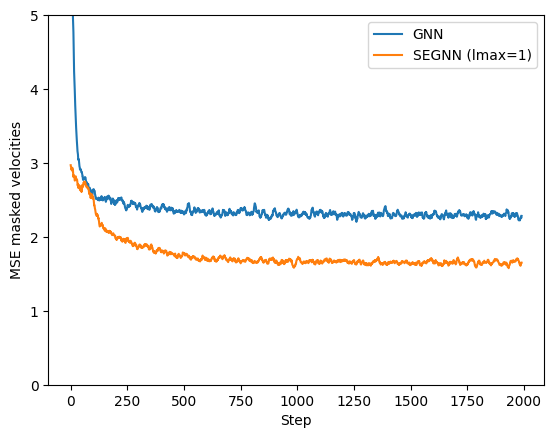

In [ ]:
ds = 10
plt.plot(np.convolve(train_loss_gnn, np.ones(ds)/ds, mode='valid'), label="GNN")
plt.plot(np.convolve(train_loss_segnn, np.ones(ds)/ds, mode='valid'), label="SEGNN (lmax=1)")
plt.ylabel('MSE masked velocities')
plt.xlabel('Step')
plt.ylim(0,5)
plt.legend()

In [ ]:
train_loss_segnn_lmax2, params_segnn_lmax2 = train_model(
    train_iterator, 
    segnn_model_lmax2, 
    n_steps=n_steps, 
    fraction_masked=fraction_masked, 
    num_local_devices=num_local_devices,
    save_model=True,
    ckpt_dir=Path(f'/global/u1/c/cuesta/eqnn-jax/benchmarks/galaxies/velocity_task/segnn_lmax2_{training_set_size}'),
)

Number of parameters: 400672


100%|██████████| 2000/2000 [15:43<00:00,  2.12it/s, loss=1.6040158]


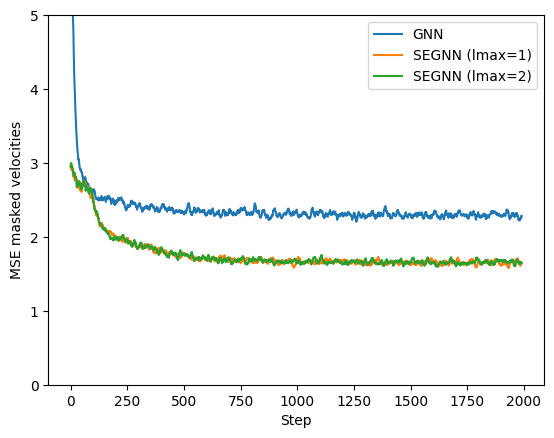

In [ ]:
ds = 10
plt.plot(np.convolve(train_loss_gnn, np.ones(ds)/ds, mode='valid'), label="GNN")
plt.plot(np.convolve(train_loss_segnn, np.ones(ds)/ds, mode='valid'), label="SEGNN (lmax=1)")
plt.plot(np.convolve(train_loss_segnn_lmax2, np.ones(ds)/ds, mode='valid'), label="SEGNN (lmax=2)")
plt.ylabel('MSE masked velocities')
plt.xlabel('Step')
plt.ylim(0,5)
plt.legend()

In [31]:
def evaluate(model, params, val_iterator):
    #n_steps = len(val_dataset) // batch_size
    n_steps = 2
    val_loss = 0.
    key = jax.random.PRNGKey(0)
    for _ in range(n_steps):
        key, subkey = jax.random.split(key)
        x_batch, _ = next(val_iterator)
        x_batch = jnp.array(x_batch)
        mask = jax.random.bernoulli(
            key,
            fraction_masked, 
            shape=(len(x_batch), x_batch.shape[1], 1)
        )
        x_batch_masked= x_batch.at[:, :, 3:6].set(
            jnp.where(mask, infill_value, x_batch[:, :, 3:6])
        )
        graph = fixed_build_graph(
            x_batch_masked,
        )
        pred = jax.jit(model.apply)(params, graph)
        pred = pred.nodes
        if isinstance(pred, e3nn.IrrepsArray):
            pred = pred.array
        val_loss += loss_mse(pred, x_batch, mask)
        plt.scatter(
            x_batch[mask[...,0], -1], 
            pred[mask[...,0], -1], 
            s=2, 
            color='firebrick', 
            alpha=0.1)
    plt.show()
    return val_loss / n_steps

In [32]:
loss_gnn = evaluate(gnn, params_gnn, val_iterator)

UnboundLocalError: local variable 'key' referenced before assignment

In [ ]:
loss_segnn = evaluate(segnn_model, params_segnn, val_iterator)

In [ ]:

loss_segnn_lmax2 = evaluate(segnn_model_lmax2, params_segnn_lmax2, val_iterator)

In [ ]:
# Visualize
x_batch, _ = next(val_iterator)
x_batch = jnp.array(x_batch)
mask = jax.random.bernoulli(
    key,
    fraction_masked, 
    shape=(len(x_batch), x_batch.shape[1], 1)
)
x_batch_masked= x_batch.at[:, :, 3:6].set(
    jnp.where(mask, infill_value, x_batch[:, :, 3:6])
)
graph = fixed_build_graph(
    x_batch_masked,
)
gnn_pred = jax.jit(gnn.apply)(params_gnn, graph)
segnn_pred = jax.jit(segnn_model.apply)(params_segnn, graph)

In [ ]:
mask